100%|██████████| 372/372 [00:15<00:00, 23.82it/s]


Validation AUC: 0.804409980171559
Validation Best threshold: 0.46168622


100%|██████████| 389/389 [00:16<00:00, 23.78it/s]


Test AUC: 0.7621869100938526
Test Best threshold: 0.4688179


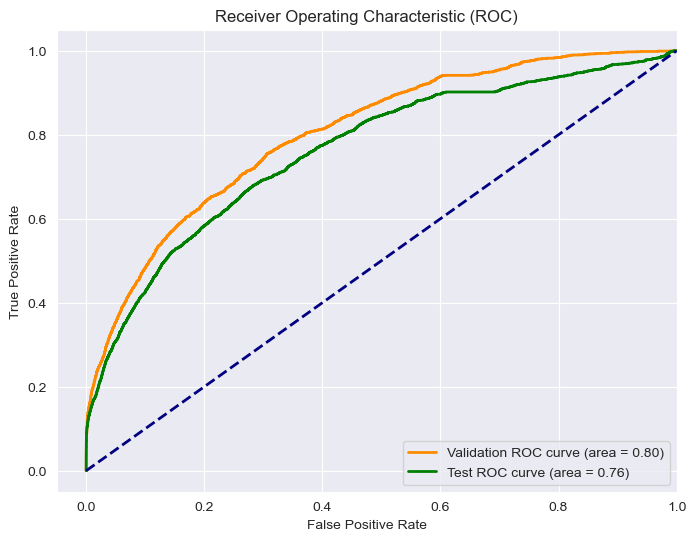

In [10]:
import numpy as np
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from main import main_data_loader

train_dataloader, val_dataloader, test_dataloader = main_data_loader(24, "less", True)
model = torch.load("保留模型/1/BiLSTM_softmax_24_8.pth", map_location="cpu")

model.eval()  # 设置为评估模式
true_labels_val = []
predicted_probs_val = []
# 对验证数据进行预测
with torch.no_grad():
    for item in tqdm(val_dataloader):
        data, targets = item
        data = data.float()
        targets = targets.long()
        outputs = model(data).float()
        true_labels_val.append(targets.numpy())
        predicted_probs_val.append(outputs.numpy())
predicted_probs_flat_val = np.concatenate(predicted_probs_val)  # 将所有预测概率展平成一个数组
true_labels_flat_val = np.concatenate(true_labels_val)  # 将所有真实标签展平成一个数组
fpr_val, tpr_val, thresholds_val = roc_curve(true_labels_flat_val, predicted_probs_flat_val)
roc_auc_val = auc(fpr_val, tpr_val)
# 选择最佳阈值
best_threshold_index_val = (1 * tpr_val - fpr_val).argmax()
best_threshold_val = thresholds_val[best_threshold_index_val]

print("Validation AUC:", roc_auc_val)
print("Validation Best threshold:", best_threshold_val)

true_labels_test = []
predicted_probs_test = []
# 对测试数据进行预测
with torch.no_grad():
    for item in tqdm(test_dataloader):
        data, targets = item
        data = data.float()
        targets = targets.long()
        outputs = model(data).float()
        true_labels_test.append(targets.numpy())
        predicted_probs_test.append(outputs.numpy())
predicted_probs_flat_test = np.concatenate(predicted_probs_test)  # 将所有预测概率展平成一个数组
true_labels_flat_test = np.concatenate(true_labels_test)  # 将所有真实标签展平成一个数组
fpr_test, tpr_test, thresholds_test = roc_curve(true_labels_flat_test, predicted_probs_flat_test)
roc_auc_test = auc(fpr_test, tpr_test)
# 选择最佳阈值
best_threshold_index_test = (1 * tpr_test - fpr_test).argmax()
best_threshold_test = thresholds_test[best_threshold_index_test]

print("Test AUC:", roc_auc_test)
print("Test Best threshold:", best_threshold_test)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label='Validation ROC curve (area = %0.2f)' % roc_auc_val)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [11]:
# 计算混淆矩阵
TP_val = np.sum((predicted_probs_flat_val > best_threshold_val) & (true_labels_flat_val == 1))
FP_val = np.sum((predicted_probs_flat_val > best_threshold_val) & (true_labels_flat_val == 0))
TN_val = np.sum((predicted_probs_flat_val <= best_threshold_val) & (true_labels_flat_val == 0))
FN_val = np.sum((predicted_probs_flat_val <= best_threshold_val) & (true_labels_flat_val == 1))

confusion_matrix_val = np.array([[TN_val, FP_val], [FN_val, TP_val]])
print("Validation Confusion Matrix:")
print(confusion_matrix_val)

specificity_val = TN_val / (TN_val + FP_val)
sensitivity_val = TP_val / (TP_val + FN_val)
accuracy_val = (TP_val + TN_val) / (TP_val + TN_val + FP_val + FN_val)

print("Validation Specificity:", specificity_val)
print("Validation Sensitivity:", sensitivity_val)
print("Validation Accuracy:", accuracy_val)


# 计算测试集混淆矩阵
TP_test = np.sum((predicted_probs_flat_test > best_threshold_test) & (true_labels_flat_test == 1))
FP_test = np.sum((predicted_probs_flat_test > best_threshold_test) & (true_labels_flat_test == 0))
TN_test = np.sum((predicted_probs_flat_test <= best_threshold_test) & (true_labels_flat_test == 0))
FN_test = np.sum((predicted_probs_flat_test <= best_threshold_test) & (true_labels_flat_test == 1))

confusion_matrix_test = np.array([[TN_test, FP_test], [FN_test, TP_test]])
print("Test Confusion Matrix:")
print(confusion_matrix_test)

specificity_test = TN_test / (TN_test + FP_test)
sensitivity_test = TP_test / (TP_test + FN_test)
accuracy_test = (TP_test + TN_test) / (TP_test + TN_test + FP_test + FN_test)

print("Test Specificity:", specificity_test)
print("Test Sensitivity:", sensitivity_test)
print("Test Accuracy:", accuracy_test)

Validation Confusion Matrix:
[[64354 28483]
 [  552  1699]]
Validation Specificity: 0.6931934465784116
Validation Sensitivity: 0.754775655264327
Validation Accuracy: 0.6946512704021538
Test Confusion Matrix:
[[69850 27310]
 [  769  1613]]
Test Specificity: 0.718917249897077
Test Sensitivity: 0.6771620486985727
Test Accuracy: 0.7179180647364931


In [12]:
for i in range(10):
    free_thresholds = i/10
    print(f"-------------------阈值分数为{i*10}:-------------------")
    # 计算混淆矩阵
    TP_val = np.sum((predicted_probs_flat_val > free_thresholds) & (true_labels_flat_val == 1))
    FP_val = np.sum((predicted_probs_flat_val > free_thresholds) & (true_labels_flat_val == 0))
    TN_val = np.sum((predicted_probs_flat_val <= free_thresholds) & (true_labels_flat_val == 0))
    FN_val = np.sum((predicted_probs_flat_val <= free_thresholds) & (true_labels_flat_val == 1))

    confusion_matrix_val = np.array([[TN_val, FP_val], [FN_val, TP_val]])
    print("Validation Confusion Matrix:")
    print(confusion_matrix_val)

    specificity_val = TN_val / (TN_val + FP_val)
    sensitivity_val = TP_val / (TP_val + FN_val)
    accuracy_val = (TP_val + TN_val) / (TP_val + TN_val + FP_val + FN_val)

    print("Validation Specificity:", specificity_val)
    print("Validation Sensitivity:", sensitivity_val)
    print("Validation Accuracy:", accuracy_val)

    # 计算测试集混淆矩阵
    TP_test = np.sum((predicted_probs_flat_test > free_thresholds) & (true_labels_flat_test == 1))
    FP_test = np.sum((predicted_probs_flat_test > free_thresholds) & (true_labels_flat_test == 0))
    TN_test = np.sum((predicted_probs_flat_test <= free_thresholds) & (true_labels_flat_test == 0))
    FN_test = np.sum((predicted_probs_flat_test <= free_thresholds) & (true_labels_flat_test == 1))

    confusion_matrix_test = np.array([[TN_test, FP_test], [FN_test, TP_test]])
    print("Test Confusion Matrix:")
    print(confusion_matrix_test)

    specificity_test = TN_test / (TN_test + FP_test)
    sensitivity_test = TP_test / (TP_test + FN_test)
    accuracy_test = (TP_test + TN_test) / (TP_test + TN_test + FP_test + FN_test)

    print("Test Specificity:", specificity_test)
    print("Test Sensitivity:", sensitivity_test)
    print("Test Accuracy:", accuracy_test)

-------------------阈值分数为0:-------------------
Validation Confusion Matrix:
[[    0 92837]
 [    0  2251]]
Validation Specificity: 0.0
Validation Sensitivity: 1.0
Validation Accuracy: 0.02367280834595322
Test Confusion Matrix:
[[    0 97160]
 [    0  2382]]
Test Specificity: 0.0
Test Sensitivity: 1.0
Test Accuracy: 0.023929597556810192
-------------------阈值分数为10:-------------------
Validation Confusion Matrix:
[[28313 64524]
 [  107  2144]]
Validation Specificity: 0.3049753869685578
Validation Sensitivity: 0.9524655708573967
Validation Accuracy: 0.3203032979976443
Test Confusion Matrix:
[[26065 71095]
 [  192  2190]]
Test Specificity: 0.26826883491148623
Test Sensitivity: 0.9193954659949622
Test Accuracy: 0.2838500331518354
-------------------阈值分数为20:-------------------
Validation Confusion Matrix:
[[42772 50065]
 [  221  2030]]
Validation Specificity: 0.46072147958249404
Validation Sensitivity: 0.9018214127054642
Validation Accuracy: 0.4711635537607269
Test Confusion Matrix:
[[43534 53

In [13]:
for i in range(10):
    free_thresholds = i/100 + 0.4
    print(f"-------------------阈值分数为{i+40}:-------------------")
    # 计算混淆矩阵
    TP_val = np.sum((predicted_probs_flat_val > free_thresholds) & (true_labels_flat_val == 1))
    FP_val = np.sum((predicted_probs_flat_val > free_thresholds) & (true_labels_flat_val == 0))
    TN_val = np.sum((predicted_probs_flat_val <= free_thresholds) & (true_labels_flat_val == 0))
    FN_val = np.sum((predicted_probs_flat_val <= free_thresholds) & (true_labels_flat_val == 1))

    confusion_matrix_val = np.array([[TN_val, FP_val], [FN_val, TP_val]])
    print("Validation Confusion Matrix:")
    print(confusion_matrix_val)

    specificity_val = TN_val / (TN_val + FP_val)
    sensitivity_val = TP_val / (TP_val + FN_val)
    accuracy_val = (TP_val + TN_val) / (TP_val + TN_val + FP_val + FN_val)

    print("Validation Specificity:", specificity_val)
    print("Validation Sensitivity:", sensitivity_val)
    print("Validation Accuracy:", accuracy_val)

    # 计算测试集混淆矩阵
    TP_test = np.sum((predicted_probs_flat_test > free_thresholds) & (true_labels_flat_test == 1))
    FP_test = np.sum((predicted_probs_flat_test > free_thresholds) & (true_labels_flat_test == 0))
    TN_test = np.sum((predicted_probs_flat_test <= free_thresholds) & (true_labels_flat_test == 0))
    FN_test = np.sum((predicted_probs_flat_test <= free_thresholds) & (true_labels_flat_test == 1))

    confusion_matrix_test = np.array([[TN_test, FP_test], [FN_test, TP_test]])
    print("Test Confusion Matrix:")
    print(confusion_matrix_test)

    specificity_test = TN_test / (TN_test + FP_test)
    sensitivity_test = TP_test / (TP_test + FN_test)
    accuracy_test = (TP_test + TN_test) / (TP_test + TN_test + FP_test + FN_test)

    print("Test Specificity:", specificity_test)
    print("Test Sensitivity:", sensitivity_test)
    print("Test Accuracy:", accuracy_test)

-------------------阈值分数为40:-------------------
Validation Confusion Matrix:
[[54162 38675]
 [  395  1856]]
Validation Specificity: 0.583409631935543
Validation Sensitivity: 0.8245224344735673
Validation Accuracy: 0.5891174490997813
Test Confusion Matrix:
[[54804 42356]
 [  476  1906]]
Test Specificity: 0.5640592836558255
Test Sensitivity: 0.8001679261125105
Test Accuracy: 0.5697092684494987
-------------------阈值分数为41:-------------------
Validation Confusion Matrix:
[[55136 37701]
 [  413  1838]]
Validation Specificity: 0.5939011385546711
Validation Sensitivity: 0.8165259884495779
Validation Accuracy: 0.5991712939592798
Test Confusion Matrix:
[[55764 41396]
 [  489  1893]]
Test Specificity: 0.5739398929600659
Test Sensitivity: 0.7947103274559194
Test Accuracy: 0.5792228406099937
-------------------阈值分数为42:-------------------
Validation Confusion Matrix:
[[56316 36521]
 [  424  1827]]
Validation Specificity: 0.6066115880521775
Validation Sensitivity: 0.8116392714349178
Validation Accurac